# 参数配置

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

use_cuda = torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# transforms
train_transforms = transforms.Compose([#transforms.RandomRotation(30),
                                       # transforms.RandomResizedCrop(224),
                                       # transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5,], [0.5,])]) # mean, std
 

test_transforms = transforms.Compose([#transforms.Resize(255),
                                      #transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5,], [0.5,])]) # mean, std

federated_train_loader = torch.utils.data.DataLoader( # <-- this is now a FederatedDataLoader 
    datasets.MNIST('/home/raoxy/data', train=True, download=True,
                   transform=train_transforms), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
    batch_size=200, shuffle=True, **kwargs)


federated_test_loader = torch.utils.data.DataLoader( # <-- this is now a FederatedDataLoader 
    datasets.MNIST('/home/raoxy/data', train=False, download=True,
                   transform=test_transforms), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
    batch_size=200, shuffle=False, **kwargs)

# LeNet

In [2]:
import torch.nn as nn


class D_CNN(nn.Module):
    def __init__(self):
        super(D_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.pool2(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.fc1(x)
        feature = nn.functional.relu(x)
        out= self.fc2(feature)
#             x = nn.functional.softmax(x, dim=1)
        return out, feature
model = D_CNN().to(device)
    
optimizer = optim.SGD(model.parameters(), lr=0.002,momentum=0.9) # TODO momentum is not supported at the moment

In [3]:
def cross_entropy_for_onehot(pred, target):
    print(pred.shape)
    print(target.shape)
    # 对预测值进行log_softmax操作，然后与目标值相乘，再求和，最后求平均
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

In [4]:
criterion =  nn.CrossEntropyLoss().to(device)

In [5]:
def compress_channel(data, k,flag="D",batch_size=200):
    if flag=="D":
        from  ksvd import ApproximateKSVD
        ksvd = ApproximateKSVD(n_components=k)
        data = data.numpy()
        output_D =  torch.empty(batch_size, 1,k, 28, dtype=torch.float, device="cpu").numpy()
        output_L = np.zeros_like(data)
        for i in range(len(data)):
            channel = data[i, 0, :, :]
            output_D[i, 0, :, :] = ksvd.fit(channel).components_
            L = ksvd.transform(channel)
    #         output_L[i, 0, :, :]  = np.clip(L, 0, 255)
        return torch.from_numpy(output_D)#torch.from_numpy(output_L)
    elif flag=="L":
        from  ksvd import ApproximateKSVD
        ksvd = ApproximateKSVD(n_components=k)
        data = data.numpy()
        output_D =  torch.empty(batch_size, 1,k, 28, dtype=torch.float, device="cpu").numpy()
        output_L = np.zeros_like(data)
        for i in range(len(data)):
            channel = data[i, 0, :, :]
            output_D[i, 0, :, :] = ksvd.fit(channel).components_
            output_L[i, 0, :, :]  = ksvd.transform(channel)
    #         output_L[i, 0, :, :]  = np.clip(L, 0, 255)
        return torch.from_numpy(output_L)#torch.from_numpy(output_L)
    else:
        from  ksvd import ApproximateKSVD
        ksvd = ApproximateKSVD(n_components=k)
        data = data.numpy()
        output_data =np.zeros_like(data)
        for i in range(len(data)):
            channel = data[i, 0, :, :]
            output_D = ksvd.fit(channel).components_
            output_L = ksvd.transform(channel)
            output_data[i, 0, :, :] =output_L.dot(output_D)
        return torch.from_numpy(output_data)

In [6]:
loss_test=[]
acc_test=[]
def test(model, device, federated_test_loader, batch_size):
    global criterion,txt,loss_test,acc_test
    model.eval()
    test_loss = 0
    correct = 0
    n=0
    with torch.no_grad():
        for data, target in federated_test_loader:
#             model.send(data.location) # <-- NEW: send the model in virtual workers to Trusted Aggregator
            ##########################################################################
#             target = target.to(device) 
#             data=compress_channel(data, 28)
#             optimizer.zero_grad()
#             output = model(data.to(device))
            ##########################################################################
            data, target = data.to(device), target.to(device)
            output, feature_fc1_graph = model(data)
            #########################################################################
            n += target.shape[0]
            loss = criterion(output, target.long())
#             loss = F.nll_loss(output, target, reduction='sum')
#             model.get()
#             test_loss += loss.get() # sum up batch loss
            test_loss += loss.item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            # print("{}\t{}".format(correct,target.shape))

    test_loss /= len(federated_test_loader)
    loss_test.append(test_loss)
    acc_test.append(correct*1.0/n)

    print('\tTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(federated_test_loader) * batch_size,
        100. * correct / n))

In [7]:
import numpy as np

loss_train=[]
acc_train=[]

def train(model, device, federated_train_loader, optimizer, epoch, batch_size):
    global out,target,criterion,loss_train,acc_train,deviation_f1_x_norm_sum,thresh,deviation_f1_x_norm,feature_fc1_graph
    model.train()
    train_loss = 0
    correct = 0
    n=0
    epsilon=1
    for batch_idx, (data, target) in enumerate(federated_train_loader): # <-- now it is a distributed dataset
        target = target.to(device) 
        data.requires_grad = True
        out, feature_fc1_graph = model(data.to(device))

        deviation_f1_target = torch.zeros_like(feature_fc1_graph) # 创建一个全零的张量，用于存储目标梯度
        deviation_f1_x_norm = torch.zeros_like(feature_fc1_graph) # 创建一个全零的张量，用于存储导数的范数
        
        for f in range(deviation_f1_x_norm.size(1)): # 对于每个特征向量的维度
            deviation_f1_target[:,f] = 1 # 将目标梯度的对应位置设为1
            feature_fc1_graph.backward(deviation_f1_target, retain_graph=True) # 对特征向量进行反向传播，计算梯度
            deviation_f1_x = data.grad.data # 获取输入的梯度
            deviation_f1_x = deviation_f1_x.to(device) # 获取输入的梯度
            deviation_f1_x_norm[:,f] = torch.norm(deviation_f1_x.view(deviation_f1_x.size(0), -1), dim=1)/ torch.where(feature_fc1_graph[:, f] == 0, torch.ones_like(feature_fc1_graph[:, f]), feature_fc1_graph[:, f])
            model.zero_grad() # 清零网络的梯度
            data.grad.data.zero_() # 清零输入的梯度
            deviation_f1_target[:,f] = 0 # 将目标梯度的对应位置设为0

        deviation_f1_x_norm_sum = deviation_f1_x_norm.sum(axis=0) # 对每个维度求和
        thresh = np.percentile(deviation_f1_x_norm_sum.flatten().cpu().detach().numpy(), epsilon) # 根据百分位数确定阈值
        mask = np.where(abs(deviation_f1_x_norm_sum.cpu()) < thresh, 0, 1).astype(np.float32)
        
        ################################################################
        n += target.shape[0]
        y = criterion(out, target.long())
        y.backward(retain_graph=True)
        
        dy_dx = torch.autograd.grad(y, model.parameters()) # 计算损失对网络参数的梯度
        original_dy_dx = list((_.detach().clone() for _ in dy_dx)) # 复制梯度
        
        #        differential privacy (DP)
        for i in range(len(original_dy_dx)):
            grad_tensor = original_dy_dx[i].cpu().numpy() # 将梯度转换为numpy数组
            noise = np.random.laplace(0,1e-1, size=grad_tensor.shape) # 生成拉普拉斯噪声DP-Laplace
            grad_tensor = grad_tensor + noise # 将梯度加上噪声
            original_dy_dx[i] = torch.Tensor(grad_tensor).to(device) # 将梯度转换为张量
        
        optimizer.step()
        pred = out.argmax(1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        train_loss+=y.item()

    train_loss /= len(federated_train_loader)
    loss_train.append(train_loss)
    acc_train.append(correct*1.0/ n)

    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(train_loss, correct, len(federated_train_loader) * batch_size,100.*correct / n))

# train(model, device, federated_train_loader, optimizer, 50, batch_size=200)

# 训练

In [8]:
for epoch in range(50):
    train(model, device, federated_train_loader, optimizer, epoch, batch_size=200)
    test(model, device, federated_test_loader, batch_size=200)

Train set: Average loss: 1.0489, Accuracy: 44682/60000 (74%)
	Test set: Average loss: 0.2729, Accuracy: 9216/10000 (92%)
Train set: Average loss: 0.2182, Accuracy: 56165/60000 (94%)
	Test set: Average loss: 0.1650, Accuracy: 9537/10000 (95%)
Train set: Average loss: 0.1438, Accuracy: 57432/60000 (96%)
	Test set: Average loss: 0.1119, Accuracy: 9675/10000 (97%)
Train set: Average loss: 0.1087, Accuracy: 58044/60000 (97%)
	Test set: Average loss: 0.0822, Accuracy: 9758/10000 (98%)
Train set: Average loss: 0.0885, Accuracy: 58415/60000 (97%)
	Test set: Average loss: 0.0716, Accuracy: 9778/10000 (98%)
Train set: Average loss: 0.0771, Accuracy: 58618/60000 (98%)
	Test set: Average loss: 0.0632, Accuracy: 9809/10000 (98%)
Train set: Average loss: 0.0675, Accuracy: 58790/60000 (98%)
	Test set: Average loss: 0.0557, Accuracy: 9818/10000 (98%)
Train set: Average loss: 0.0618, Accuracy: 58899/60000 (98%)
	Test set: Average loss: 0.0555, Accuracy: 9826/10000 (98%)
Train set: Average loss: 0.0561,

# 分析

In [9]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
mpl.use('nbAgg')

In [10]:
import pandas as pd
df=pd.DataFrame([loss_train, loss_test, acc_train, acc_test]).T
df.columns =['loss_train', 'loss_test','acc_train','acc_test']
# df.to_csv("/home/raoxy/file/{}".format(save_name),index=False)
mpl.style.use('seaborn-white')

<IPython.core.display.Javascript object>


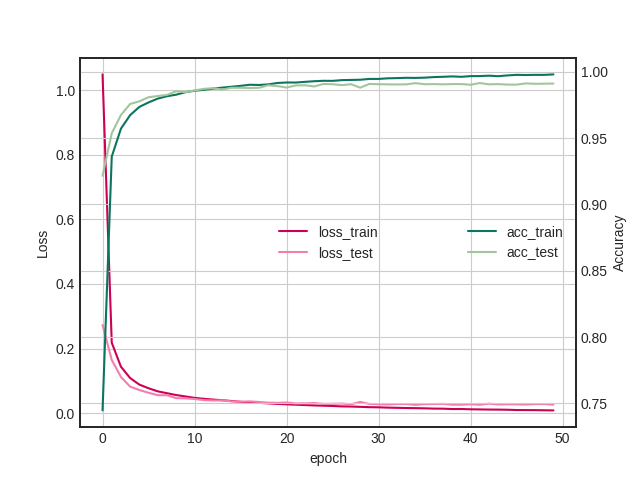

In [11]:
# 将DataFrame中的数据进行可视化，设置两个y轴
ax = df[['loss_train', 'loss_test']].plot(color=['#CD0056','#F47EAB'])
# 创建一个新的Axes对象，共享x轴
ax2 = ax.twinx()
# 绘制'acc_train'和'acc_test'在右侧y轴
df[['acc_train', 'acc_test']].plot(ax=ax2, color=['#0C755F', '#A2C69B'])
# 设置左侧y轴标签
ax.set_ylabel('Loss')
ax.set_xlabel('epoch')
# 设置右侧y轴标签
ax2.set_ylabel('Accuracy')
ax.grid(True)
ax2.grid(True)
ax.legend(loc='center')
ax2.legend(loc='center right')
# 显示图形
plt.show()

# 保存模型

In [13]:
# 保存模型参数
model_name="DP-Laplace_MNIST"
torch.save(model.state_dict(), "{}.pth".format(model_name))
# 加载模型参数
# model = TheModelClass(*args, **kwargs) # 先定义好模型结构
# model.load_state_dict(torch.load("{}.pth".format(model_name)) # 再加载参数
# model.eval() # 设置为评估模式

In [14]:
# 保存整个模型
torch.save(model, "{}.pt".format(model_name))
# 加载整个模型
# model = torch.load("model_name.pt")
# model.eval() # 设置为评估模式

In [22]:
import pandas as pd
df=pd.DataFrame([loss_train, loss_test, acc_train, acc_test]).T
df.columns =['loss_train', 'loss_test','acc_train','acc_test']
df.to_csv("file/{}.csv".format(model_name),index=False)
mpl.style.use('seaborn-white')

# 模型评价

In [15]:
# 导入所需的库和模块
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc

# 定义设备，可以是 CPU 或 GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 加载MNIST数据集，并进行预处理
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

testset = torchvision.datasets.MNIST(root='/home/raoxy/data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3', '4',
           '5', '6', '7', '8', '9')

In [16]:
# # 定义CNN网络的结构
class D_CNN(nn.Module):
    def __init__(self):
        super(D_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.pool2(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.fc1(x)
        feature = nn.functional.relu(x)
        out= self.fc2(feature)
#             x = nn.functional.softmax(x, dim=1)
        return out, feature
# # 加载训练好的 .pt 文件
model = D_CNN()
model.load_state_dict(torch.load('/home/raoxy/iov-fl/DP-Laplace_MNIST.pth', map_location=device))
model.to(device)

D_CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
)

In [17]:
loss_test=[]
acc_test=[]
y_true=[]
y_pred=[]
log_softmax = nn.LogSoftmax(dim=1)
def Pre(model, device, federated_test_loader, batch_size=200):
    global criterion,txt,loss_test,acc_test
    model.eval()
    test_loss = 0
    correct = 0
    n=0
    with torch.no_grad():
        for data, target in federated_test_loader:
            data, target = data.to(device), target.to(device)
            output, feature_fc1_graph = model(data)
#             print(model(data))
#             break
            output = log_softmax(output)
            n += target.shape[0]
            loss = criterion(output, target.long())
            test_loss += loss.item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
#             print("{}\t{}\t{}".format(pred.shape,target.shape,accuracy_score(pred.cpu(), target.cpu())))
            y_true.extend(target.cpu().numpy())
            y_pred.extend(pred.squeeze().cpu().numpy())

    test_loss /= len(federated_test_loader)
    loss_test.append(test_loss)
    acc_test.append(correct*1.0/n)

    print('\tTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(federated_test_loader) * batch_size,
        100. * correct / n))
    return y_true,y_pred

In [18]:
y_true,y_pred=Pre(model, device, federated_test_loader, batch_size=200)

	Test set: Average loss: 2.5981, Accuracy: 982/10000 (10%)


## 计算精度

In [19]:
from sklearn.metrics import accuracy_score  # pip install scikit-learn
accuracy = accuracy_score(y_true, y_pred)
print("精度: ",accuracy)

精度:  0.0982


## 绘制混淆矩阵

<IPython.core.display.Javascript object>


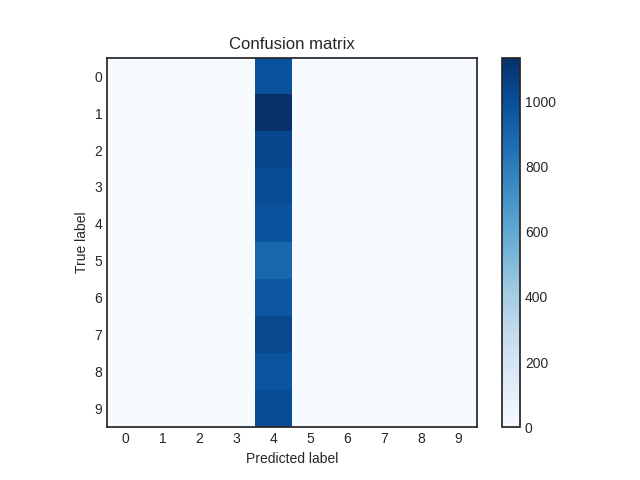

In [20]:
confusion = confusion_matrix(y_true, y_pred)
plt.imshow(confusion, cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

## 计算AUC值

<IPython.core.display.Javascript object>


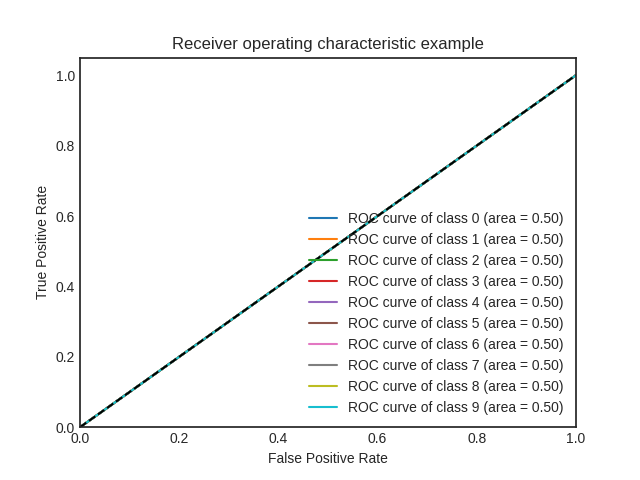

In [21]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# 绘制ROC曲线
plt.figure()
for i in range(10):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()